general linear models are linear regressions
```
y = ax + b
```

generalized linear models include logistic regression
```
g(y) = ax + b
where g is called the link function, eg logit g(p) = ln(p/(1-p)) for binary y, or log for count y
```

# Part 1: Schezophrenia and smoking

This is an [example](http://psych.colorado.edu/~carey/qmin/qminChapters/QMIN09-GLMIntro.pdf)
from Gregory Carey from UC Boulder.

We know that schizophrenics smoke a lot. Following up, we wonder:
- Do schizophrenics have more or fewer nicotinic receptors [nAChRs](https://en.wikipedia.org/wiki/Nicotinic_acetylcholine_receptor) in their brain?
- We measure receptor density from autopsies. The density may vary with age, and schizophrenia may impact lifespan. 
If schizophrenics have different nAChRs, is it simply related to them dying earlier/later?
- We rarely know smoking status at death, but can use [cotinine](https://en.wikipedia.org/wiki/Cotinine) 
as proxy for nicotine intake. 
If schizophrenics have different nAChRs, is it simply related to them having smoked more?
- Is age or cotinine related to nAChRs more or less than schizo?

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
from io import StringIO
import seaborn as sns


# data from Gregory Carey, UC Boulder 
# http://psych.colorado.edu/~carey/qmin/qminChapters/QMIN09-GLMIntro.pdf
df = pd.read_csv('schizophrenia_smoking.csv')
df.head()

,patient,schizo,schizo_bool,age,smoke,cotinine,nachr
0,1,No,0,55,No,2.00,18.53
1,2,No,0,83,No,9.03,11.73
2,3,No,0,52,NaN,5.60,19.01
3,4,No,0,74,No,2.00,25.93
4,5,No,0,61,No,2.00,21.66


nachr by schizo: Yes=18.28, No=19.99
t-test: t=-0.69, p=0.50


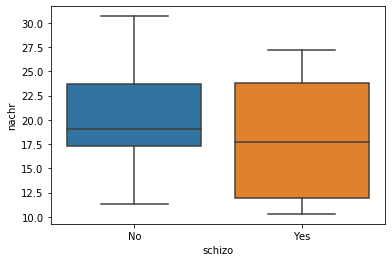

In [2]:
# Do schizophrenics have more or fewer nicotinic receptors nAChRs in their brain? 
# answer: unclear (yet)

def boxplot_and_ttest(df, outcome_colname, group_colname, group_values):
    """ 
    Conduct t-test on df for the 2 groups passed.
    Plot boxplot of outcome variable split by the 2 groups.
    
    df: has at least 2 columns
    outcome_colname: the name of column for outcome,
    group_colname: name of column for groups,
    group_values: 2-tuple with each group
    """
    
    
    group_val_c, group_val_t = group_values[:2]
    data_c = df.query(f'{group_colname}=="{group_val_c}"')[outcome_colname]
    data_t = df.query(f'{group_colname}=="{group_val_t}"')[outcome_colname]
    
    # print 2 means and t-test
    print(
        f'{outcome_colname} by {group_colname}:',
        f'{group_val_c}={data_c.mean():.2f},',
        f'{group_val_t}={data_t.mean():.2f}'
    )
    t, p = stats.ttest_ind(data_c, data_t)
    print(f't-test: t={t:.2f}, p={p:.2f}')
    
    # boxplot
    ax = sns.boxplot(group_colname, outcome_colname, data=df)

    
# looks like schizo have fewer nachr, but not sig    
boxplot_and_ttest(df, 'nachr', 'schizo', ('Yes', 'No'))

In [3]:
def pretty_print_ols_summary(fit):
    """ concise alternative to sm.OLS().fit().summary() """
    # use dir(fit) to list properties
#      + '+'.join(fit.params.keys())
    formula = fit.model.endog_names+ ' ~ '+ ' + '.join(fit.model.exog_names)
    print(formula, f'---- adj r2={fit.rsquared_adj:.2f}')
    for param, beta in fit.params.items():
        print(f'-- {param}: beta={beta:.2f}, p={fit.pvalues.get(param):.2f}')


def ols_fit(df, outcome_colname, predictor_colnames, add_intercept=True):
    """ ordinary least square fit on dataframe """
    data = df[predictor_colnames].copy() # avoid warning of setting on copy
    data['intercept'] = 1
    linreg = sm.OLS(df[outcome_colname], data)
    return linreg.fit()


# check we get control's mean, and same pvalue of .50 as t-test. Also low r2.
fit = ols_fit(df, 'nachr', ['schizo_bool'])
pretty_print_ols_summary(fit)


nachr ~ schizo_bool + intercept ---- adj r2=-0.02
-- schizo_bool: beta=-1.71, p=0.50
-- intercept: beta=19.99, p=0.00


In [4]:
# add age: age is sig, schizo still not sig. Medium r2?
# Age at death decreases nachr, controlling for schizo. 
fit = ols_fit(df, 'nachr', ['schizo_bool','age'])
pretty_print_ols_summary(fit)

nachr ~ schizo_bool + age + intercept ---- adj r2=0.25
-- schizo_bool: beta=-2.77, p=0.21
-- age: beta=-0.18, p=0.01
-- intercept: beta=32.61, p=0.00


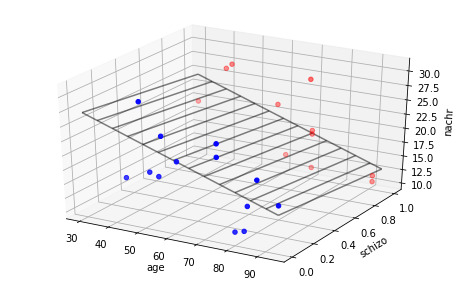

In [5]:
from mpl_toolkits.mplot3d import Axes3D

# 3d plot nachr against age and schizo
# TODO: 2d plot with 1 fit for schizo, 1 fit for control

def plot3d_scatter(x, y, z, planar_fit_coefs=(), colorby=None, labels=()):
    """ 3d scatter plot with planar fit, if provided
    https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html
    """
    fig = plt.figure(figsize=(8,5)) # so z label fits
    ax = fig.add_subplot(111,projection='3d')

    ax.scatter(x, y, z, c=colorby, cmap='bwr')
    
    # plot planar fit https://stackoverflow.com/a/36061408
    if planar_fit_coefs:
        xx, yy = np.meshgrid(
            range(min(x), max(x)+1),
            range(min(y), max(y)+1)
        ) 
        a, b, c = planar_fit_coefs
        zz = a + b * xx + c * yy
#         ax.plot_surface(xx, yy, zz, cmap='viridis',alpha=0.5)
#         ax.contour3D(xx,yy,zz, 50, cmap='viridis')
        ax.plot_wireframe(xx,yy,zz, color='black', cstride=5, alpha=.5)
    
    if labels: # label axes
        xl, yl, zl = labels
        ax.set_xlabel(xl)
        ax.set_ylabel(yl)
        ax.set_zlabel(zl)
    
    plt.show()
 

plot3d_scatter(
    x=df['age'], 
    y=df['schizo_bool'], 
    z=df['nachr'], 
    planar_fit_coefs=(32.61, -0.18, -2.77), # hardcoded betas
    colorby=df['schizo_bool'],
    labels=('age','schizo','nachr')
)

In [6]:
# add cotinine: now all 3 are sig. Big r2!
# why is it sig only now and not earlier? 
# Because cotinine confounded the relationship between schizo and nachrs.
# Notice how schizo betas and R2 have been going up when adding more factors.
fit = ols_fit(df, 'nachr', ['schizo_bool','age','cotinine'])
pretty_print_ols_summary(fit)

nachr ~ schizo_bool + age + cotinine + intercept ---- adj r2=0.44
-- schizo_bool: beta=-5.70, p=0.01
-- age: beta=-0.12, p=0.04
-- cotinine: beta=0.08, p=0.01
-- intercept: beta=26.20, p=0.00


In [7]:
# Is age or cotinine related to nAChRs more or less than schizo?
# Answer: age and cotinine are both continuous and comparable. 
# Cotinine has a stronger relation with nachrs than age 
# (gain of +.56 sd of nachr for a 1sd change in age, vs -.37sd for cotinine).
# Having schizo is categorical, and not comparable to numerical vars.

# normalize all quant predictors and quant outcome, then linreg
norm_df = df[['schizo_bool','age','cotinine']].copy()
norm_df['age_norm'] = (norm_df['age'] - norm_df['age'].mean()) / norm_df['age'].std()
norm_df['cotinine_norm'] = (norm_df['cotinine'] - norm_df['cotinine'].mean()) / norm_df['cotinine'].std()
norm_df['intercept'] = 1
y = df['nachr']
y = (y - y.mean()) / y.std()
data = norm_df[['age_norm','cotinine_norm','schizo_bool','intercept']]
linreg = sm.OLS(y, data)
linreg_fit = linreg.fit()
linreg_fit.summary() 
pretty_print_ols_summary(linreg_fit)
# +1 sd in age = -.37 sd in nachr
# +1 sd in cotinine = +.56 sd in nachr
# having schizo = -.95 sd in nachr

nachr ~ age_norm + cotinine_norm + schizo_bool + intercept ---- adj r2=0.44
-- age_norm: beta=-0.37, p=0.04
-- cotinine_norm: beta=0.56, p=0.01
-- schizo_bool: beta=-0.95, p=0.01
-- intercept: beta=0.44, p=0.06


# Part 2: star 98 dataset

Using the Star98 dataset from `Jeff Gill (2000) Generalized linear models: A unified approach`. 

[Source code](https://www.statsmodels.org/dev/examples/notebooks/generated/glm.html#GLM:-Binomial-response-data)

Data
- Around 300 California counties.
- 2 outcomes: number of students above/below national median test score.
- a dozen predictors, like county's proportion of low-income students or proportion of minority teachers.

The general idea is to regress the 2 counts, as a binomial outcome, against the dozen predictors.
A naive linear regression isn't adequate because the outcome isn't gaussian.
So we use a binomial link.


In [8]:
%matplotlib inline
import numpy as np
import statsmodels.api as sm
from scipy import stats
from matplotlib import pyplot as plt

"""
some good resources
- gentle intro to glm http://psych.colorado.edu/~carey/qmin/qminChapters/QMIN09-GLMIntro.pdf
- anova vs ancova https://psych.unl.edu/psycrs/942/q3/ancova_142.pdf
- general vs generalized linear models vs GAM  https://www.quora.com/What-is-the-difference-between-general-linear-models-and-generalized-linear-models
https://learnerworld.tumblr.com/post/152330635640/enjoystatisticswithme
gist of it is: general is lin reg, generalized is log reg (eg predict a yes/no).
- Jeff Gill 2000 https://www.amazon.com/Generalized-Linear-Models-Quantitative-Applications-ebook-dp-B07VMYLJQR/dp/B07VMYLJQR/ref=mt_kindle?_encoding=UTF8&me=&qid=#reader_B07VMYLJQR
- 

"""
print(sm.datasets.star98.NOTE) # codebook

::

    Number of Observations - 303 (counties in California).

    Number of Variables - 13 and 8 interaction terms.

    Definition of variables names::

        NABOVE   - Total number of students above the national median for the
                   math section.
        NBELOW   - Total number of students below the national median for the
                   math section.
        LOWINC   - Percentage of low income students
        PERASIAN - Percentage of Asian student
        PERBLACK - Percentage of black students
        PERHISP  - Percentage of Hispanic students
        PERMINTE - Percentage of minority teachers
        AVYRSEXP - Sum of teachers' years in educational service divided by the
                number of teachers.
        AVSALK   - Total salary budget including benefits divided by the number
                   of full-time teachers (in thousands)
        PERSPENK - Per-pupil spending (in thousands)
        PTRATIO  - Pupil-teacher ratio.
        PCTAF    - Percenta

In [9]:
def prep_star_data(add_intercept = True):
    """ return tuple: 
    pandas dataframe, 
    list of outcome column names, 
    list of predictor column names
    
    Note: this returns 2 y columns, because binomial expects 
    one for success (above national median) and one for failures (below).
    """
    dataset = sm.datasets.star98.load(as_pandas=True) # Dataset with 3 df: data, endog, and exog.
    df = dataset.data
    outcome_cols = list(dataset.endog.columns)
    predictor_cols = list(dataset.exog.columns) 
    
    if add_intercept:
        df['intercept'] = 1
        predictor_cols += ['intercept']
        
    return df, outcome_cols, predictor_cols


df, y_cols, x_cols = prep_star_data()
print('outcomes: ', y_cols)
print('predictors: ', x_cols)
df.head()


outcomes:  ['NABOVE', 'NBELOW']
predictors:  ['LOWINC', 'PERASIAN', 'PERBLACK', 'PERHISP', 'PERMINTE', 'AVYRSEXP', 'AVSALK', 'PERSPENK', 'PTRATIO', 'PCTAF', 'PCTCHRT', 'PCTYRRND', 'PERMINTE_AVYRSEXP', 'PERMINTE_AVSAL', 'AVYRSEXP_AVSAL', 'PERSPEN_PTRATIO', 'PERSPEN_PCTAF', 'PTRATIO_PCTAF', 'PERMINTE_AVYRSEXP_AVSAL', 'PERSPEN_PTRATIO_PCTAF', 'intercept']


,NABOVE,NBELOW,LOWINC,PERASIAN,PERBLACK,PERHISP,PERMINTE,AVYRSEXP,AVSALK,PERSPENK,...,PCTYRRND,PERMINTE_AVYRSEXP,PERMINTE_AVSAL,AVYRSEXP_AVSAL,PERSPEN_PTRATIO,PERSPEN_PCTAF,PTRATIO_PCTAF,PERMINTE_AVYRSEXP_AVSAL,PERSPEN_PTRATIO_PCTAF,intercept
0,452.0,355.0,34.39730,23.299300,14.235280,11.411120,15.91837,14.70646,59.15732,4.445207,...,22.222220,234.102872,941.68811,869.9948,96.50656,253.52242,1238.1955,13848.8985,5504.0352,1
1,144.0,40.0,17.36507,29.328380,8.234897,9.314884,13.63636,16.08324,59.50397,5.267598,...,0.000000,219.316851,811.41756,957.0166,107.68435,340.40609,1321.0664,13050.2233,6958.8468,1
2,337.0,234.0,32.64324,9.226386,42.406310,13.543720,28.83436,14.59559,60.56992,5.482922,...,0.000000,420.854496,1746.49488,884.0537,103.92435,295.75929,1022.4252,25491.1232,5605.8777,1
3,395.0,178.0,11.90953,13.883090,3.796973,11.443110,11.11111,14.38939,58.33411,4.165093,...,7.142857,159.882095,648.15671,839.3923,90.11341,204.34375,1061.4545,9326.5797,4421.0568,1
4,8.0,57.0,36.88889,12.187500,76.875000,7.604167,43.58974,13.90568,63.15364,4.324902,...,0.000000,606.144976,2752.85075,878.1943,81.22097,226.54248,983.7059,38280.2616,4254.4314,1


In [10]:
glm_binom = sm.GLM(df[y_cols], df[x_cols], family=sm.families.Binomial())
res = glm_binom.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                   
================================================================================
Dep. Variable:     ['NABOVE', 'NBELOW']   No. Observations:                  303
Model:                              GLM   Df Residuals:                      282
Model Family:                  Binomial   Df Model:                           20
Link Function:                    logit   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -2998.6
Date:                  Tue, 21 Jan 2020   Deviance:                       4078.8
Time:                          22:05:33   Pearson chi2:                 4.05e+03
No. Iterations:                       5                                         
Covariance Type:              nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
LOWINC                     -0.0168      0.000    -38.749      0.000      -0.018      -0.016
PERASIAN                    0.0099      0.001     16.505      0.000       0.009       0.011
PERBLACK                   -0.0187      0.001    -25.182      0.000      -0.020      -0.017
PERHISP                    -0.0142      0.000    -32.818      0.000      -0.015      -0.013
PERMINTE                    0.2545      0.030      8.498      0.000       0.196       0.313
AVYRSEXP                    0.2407      0.057      4.212      0.000       0.129       0.353
AVSALK                      0.0804      0.014      5.775      0.000       0.053       0.108
PERSPENK                   -1.9522      0.317     -6.162      0.000      -2.573      -1.331
PTRATIO                    -0.3341      0.061     -5.453      0.000      -0.454      -0.214
PCTAF                      -0.1690      0.033     -5.169      0.000      -0.233      -0.105
PCTCHRT                     0.0049      0.001      3.921      0.000       0.002       0.007
PCTYRRND                   -0.0036      0.000    -15.878      0.000      -0.004      -0.003
PERMINTE_AVYRSEXP          -0.0141      0.002     -7.391      0.000      -0.018      -0.010
PERMINTE_AVSAL             -0.0040      0.000     -8.450      0.000      -0.005      -0.003
AVYRSEXP_AVSAL             -0.0039      0.001     -4.059      0.000      -0.006      -0.002
PERSPEN_PTRATIO             0.0917      0.015      6.321      0.000       0.063       0.120
PERSPEN_PCTAF               0.0490      0.007      6.574      0.000       0.034       0.064
PTRATIO_PCTAF               0.0080      0.001      5.362      0.000       0.005       0.011
PERMINTE_AVYRSEXP_AVSAL     0.0002   2.99e-05      7.428      0.000       0.000       0.000
PERSPEN_PTRATIO_PCTAF      -0.0022      0.000     -6.445      0.000      -0.003      -0.002
intercept                   2.9589      1.547      1.913      0.056      -0.073       5.990
===========================================================================================
"""